In [ ]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 414, done.
remote: Counting objects: 100% (164/164), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 414 (delta 104), reused 79 (delta 79), pack-reused 250
Receiving objects: 100% (414/414), 70.33 MiB | 25.32 MiB/s, done.
Resolving deltas: 100% (198/198), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=28255 sha256=d48ce1588cdcfb008417358e4056017e18f91417ed4a2e7c7c0fe9bc4fb91fd7
  Stored in directory: /tmp/pip-ephem-wheel-cache-dgpyhp30/wheels/55/59/29/0fb1c635652157

In [ ]:
from dul_2021.utils.hw13_utils import *

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
import os
import numpy as np
import copy
from itertools import chain

import torch.utils.data as data
from tqdm import trange
import torch
import torch.nn as nn
import torch.optim as opt
from torch.autograd import Variable
import torch.nn.functional as F
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Question 1: RealNVP on Higher Dimensions


In this problem, you will train a flow model to invertibly map a high dimensional dataset of celebrity
faces to gaussian noise. The dataset is a low-resolution (32 × 32) version of the CelebA-HQ dataset that has been quantized to 2 bits per color channel.



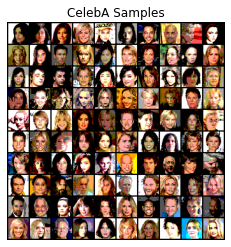

In [ ]:
visualize_q1_data()

In [ ]:
train_data, test_data = get_q1_data()

In [ ]:
train_data.shape

(20000, 32, 32, 3)

In [ ]:
train_data.min(), train_data.max()

(0, 3)

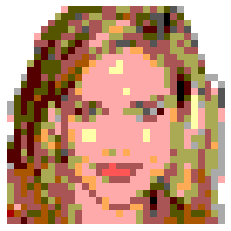

In [ ]:
plt.imshow((train_data[9000].astype(np.float32) / 3.0 * 255.0).astype(np.uint8))
plt.axis('off')
plt.show()

## Part (a): RealNVP


Use the affine coupling flow from RealNVP and a form of [data-dependent initialization](https://arxiv.org/abs/1602.07868) that normalizes activations from an initial forward pass with a minibatch.
We describe a reference architecture below that can achieve good performance, but you are free
and encouraged to use different architectures and/or structure your code differently.



```
Preprocess() # dequantization, logit trick from RealNVP (Dinh et al) Section 4.1

for _ in range(4):
  AffineCouplingWithCheckerboard() # Figure 3 in Dinh et al - (left)
  ActNorm() # described in Glow (Kingma & Dhariwal) Section 3.1
Squeeze(), # [b, c, h, w] --> [b, c*4, h//2, w//2]

for _ in range(3):
  AffineCouplingWithChannel()
  ActNorm()
Unsqueeze(), # [b, c*4, h//2, w//2] --> [b, c, h, w]

for _ in range(3):
  AffineCouplingWithCheckerboard()
  ActNorm()
```



Here, we provide pseudocode for the basic structure of each coupling layer. 



```
# pseudocode
ResnetBlock: n_filters
  h = x
  h = conv2d(n_filters, n_filters, (1,1), stride=1, padding=0)(h)
  h = relu(h)
  h = conv2d(n_filters, n_filters, (3,3), stride=1, padding=1)(h)
  h = relu(h)
  h = conv2d(n_filters, n_filters, (1,1), stride=1, padding=0)(h)
  return h + x

SimpleResnet: n_filters = 256, n_blocks = 8, n_out
  conv2d(in_channels, n_filters=128, (3,3), stride=1, padding=1)
  apply 8 ResnetBlocks with n_filters=128
  relu()
  conv2d(n_filters, n_filters=n_out, (3,3), stride=1, padding=1)
  
AffineCoupling(x, mask):
  x_ = x * mask
  log_s, t = torch.chunk(SimpleResnet(x_), 2, dim=1)
  # todo: calculate log_scale, as done in Q1(b)
  t = t * (1.0 - mask)
  log_scale = log_scale * (1.0 - mask)
  z = x * torch.exp(log_scale) + t
  log_det_jacobian = log_scale
  return z, log_det_jacobian
```



We use an Adam Optimizer with a warmup over 200 steps till a learning rate of 5e-4. We didn’t decay the learning rate but it is a generally recommended practice while training generative models. We show samples from our model at the end of training, as well as interpolations between several images in our dataset.  Our reference solution achieves a test loss of about 0.40 bits/dim after 100 epochs. 



**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model
4. 5 rows of interpolations between images in the test set; each row consists of the start and end images, and 4 intermediate ones. You should return 30 total images. 



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
class ResnetBlock(nn.Module):
    def __init__(self, n_filters,):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv2d(n_filters, n_filters, (1, 1), stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(n_filters, n_filters, (3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(n_filters, n_filters, (1, 1), stride=1, padding=0),
            )

    def forward(self, x):
        return self.block(x) + x


class SimpleResnet(nn.Module):
    def __init__(self, n_in, n_out, n_filters=128, n_blocks=8,):
        super().__init__()

        layers = [nn.Conv2d(n_in, n_filters, (3, 3), stride=1, padding=1)]
        layers.extend([ResnetBlock(n_filters)] * n_blocks)
        layers.extend([nn.ReLU(),
                       nn.Conv2d(n_filters, n_out, (3, 3), stride=1, padding=1)])
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class ActNorm(nn.Module):
    def __init__(self, n_channels=3):
        super().__init__()

        self.log_scale = nn.Parameter(torch.zeros(1, n_channels, 1, 1), requires_grad=True)
        self.shift = nn.Parameter(torch.zeros(1, n_channels, 1, 1), requires_grad=True)
        
        self.n_channels = n_channels
        self.initialized = False

    def forward(self, x, reverse=False):
        if reverse:
            return (x - self.shift) * torch.exp(-self.log_scale), self.log_scale
        else:
            if not self.initialized:
                self.log_scale.data =  - torch.log(torch.std(x, dim=[0, 2, 3])).reshape(1, self.n_channels, 1, 1)
                self.shift.data = -torch.mean(x, dim=[0, 2, 3], keepdim=True) * torch.exp(self.log_scale.data)
                self.initialized = True
                
            return x * torch.exp(self.log_scale) + self.shift, self.log_scale


In [ ]:
class AffineCouplingWithCheckerboard(nn.Module):
    def __init__(self, n_in=3, n_out=6, n_filters=128, n_blocks=2, img_size=(32, 32), mask_type=1): # n_blocks=8
        super().__init__()
        self.model = SimpleResnet(n_in, n_out)
        self.mask = self.build_mask(img_size[0], img_size[1], mask_type=mask_type)
        self.scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True)

    def build_mask(self, h, w, mask_type):
        x, y = torch.arange(h), torch.arange(w)
        xx, yy = torch.meshgrid(x, y)
        mask = (xx + yy) % 2
        mask = mask.float()[None, None, :, :].to(device)
        if mask_type == 2:
            mask = 1.0 - mask
        return mask


    def forward(self, x, reverse=False):
        """
            В mask 1 стоит на тех местах, что в z тождественно будет равняться x,
            то есть для x_{1: d}
        """

        x_ = x * self.mask
        log_scale, t = torch.chunk(self.model(x_), 2, dim=1)
        log_scale = self.scale * torch.tanh(log_scale) + self.scale_shift

        # z = x * log_scale.exp() + t
        # z = z * (1.0 - self.mask)
        # z = z + x_

        # log_det_jacobian = (log_scale * (1.0 - self.mask)).sum().exp()
        # return z, log_det_jacobian

        ##############

        t = t * (1.0 - self.mask)
        log_scale = log_scale * (1.0 - self.mask)

        if reverse: 
            x = (x - t) * torch.exp(-log_scale)
        else:
            x = x * torch.exp(log_scale) + t
        return x, log_scale
        ###########


class AffineCouplingWithChannel(nn.Module):
    def __init__(self, n_in=12, n_out=24, n_filters=128, n_blocks=2, mask_type=1): # n_blocks=8
        super().__init__()
        self.model = SimpleResnet(n_in, n_out)
        self.mask = self.build_mask(n_in, mask_type=mask_type)
        self.scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True)

    def build_mask(self, channels, mask_type):
        mask = torch.cat([torch.ones(channels // 2), 
                          torch.zeros(channels - channels // 2)]).to(device)
        mask = mask.float()[None, :, None, None]
        if mask_type == 2:
            mask = 1.0 - mask
        return mask


    def forward(self, x, reverse=False):
        """
            В mask 1 стоит на тех местах, что в z тождественно будет равняться x,
            то есть для x_{1: d}
        """

        # batch_size = x.shape[0]
        # mask = self.mask.repeat(batch_size, 1)

        x_ = x * self.mask
        log_scale, t = torch.chunk(self.model(x_), 2, dim=1)
        log_scale = self.scale * torch.tanh(log_scale) + self.scale_shift


        # z = x * log_scale.exp() + t
        # z = z * (1.0 - self.mask)
        # z = z + x_

        # log_det_jacobian = (log_scale * (1.0 - self.mask)).sum().exp()
        # return z, log_det_jacobian

        ##############
        t = t * (1.0 - self.mask)
        log_scale = log_scale * (1.0 - self.mask)

        if reverse: 
            x = (x - t) * torch.exp(-log_scale)
        else:
            x = x * torch.exp(log_scale) + t
        return x, log_scale
        ###########

In [ ]:
class RealNVP(nn.Module):
    def __init__(self,):
        super().__init__()

        self.prior = torch.distributions.Normal(torch.tensor(0.).to(device), 
                                                torch.tensor(1.).to(device))
        # self.transforms_1 = nn.ModuleList([AffineCouplingWithCheckerboard(mask_type=1), ActNorm(3),
        #                                    AffineCouplingWithCheckerboard(mask_type=2), ActNorm(3),
        #                                    AffineCouplingWithCheckerboard(mask_type=1), ActNorm(3),
        #                                    AffineCouplingWithCheckerboard(mask_type=2), ActNorm(3)])
        # self.transforms_2 = nn.ModuleList([AffineCouplingWithChannel(mask_type=1), ActNorm(12),
        #                                    AffineCouplingWithChannel(mask_type=2), ActNorm(12),
        #                                    AffineCouplingWithChannel(mask_type=1), ActNorm(12)])
        # self.transforms_3 = nn.ModuleList([AffineCouplingWithCheckerboard(mask_type=2), ActNorm(3),
        #                                    AffineCouplingWithCheckerboard(mask_type=1), ActNorm(3),
        #                                    AffineCouplingWithCheckerboard(mask_type=2), ActNorm(3)])
        
        self.transforms_1 = nn.ModuleList([AffineCouplingWithCheckerboard(mask_type=1), ActNorm(3),
                                           AffineCouplingWithCheckerboard(mask_type=2), ActNorm(3),])
        self.transforms_2 = nn.ModuleList([AffineCouplingWithChannel(mask_type=1), ActNorm(12),
                                           AffineCouplingWithChannel(mask_type=2), ActNorm(12),])
        self.transforms_3 = nn.ModuleList([AffineCouplingWithCheckerboard(mask_type=1), ActNorm(3),
                                           AffineCouplingWithCheckerboard(mask_type=2), ActNorm(3)])


    def preprocess(self, x, alpha=0.05, max_value=4, reverse=False):
        if reverse:
            x = 1 + -1 / (x.exp() + 1) 
            x = x - alpha
            x = x / (1 - alpha)
            x = x * max_value
            return x
        else:
            x = x / max_value
            x = (1 - alpha) * x
            x = alpha + x
            return x.logit()

    def squeeze(self, x):
        """
            каналов станет в 4 раза больше, 
            размеры уменьшатся в 2 раза
            
            bs x C x H x W --> bs x 4C x H/2 x W/2
        """

        bs, C, H, W = x.shape
        x = x.reshape(bs, C, H, W // 2, 2) # redundant
        x = x.reshape(bs, C, H // 2, 2, W // 2, 2)
        x = x.permute(0, 1, 3, 5, 2, 4)
        x = x.reshape(bs, C * 4, H // 2, W // 2)
        return x

    def unsqueeze(self, x):
        """
            каналов станет в 4 раза меньше, 
            размеры увеличиваются в 2 раза
            
            bs x 4C x H/2 x W/2 --> bs x C x H x W
        """
        bs, four_C, half_H, half_W = x.shape
        C = four_C // 4
        H = half_H * 2
        W = half_W * 2

        x = x.reshape(bs, C, 2, 2, H // 2, W // 2)
        x = x.permute(0, 1, 4, 2, 5, 3)

        x = x.reshape(bs, C, H, W // 2, 2)
        x = x.reshape(bs, C, H, W)

        return x
    
    def flow(self, x):
        z = self.preprocess(x)
        log_det = torch.zeros_like(x)

        for op in self.transforms_1:
            z, delta_log_det = op.forward(z)
            log_det += delta_log_det

        z = self.squeeze(z)
        log_det = self.squeeze(log_det)
        for op in self.transforms_2:
            z, delta_log_det = op.forward(z)
            log_det += delta_log_det

        z = self.unsqueeze(z)
        log_det = self.unsqueeze(log_det)
        for op in self.transforms_3:
            z, delta_log_det = op.forward(z)
            log_det += delta_log_det
        return z, log_det

    def invert_flow(self, z):
        for op in reversed(self.transforms_3):
            z, _ = op.forward(z, reverse=True)

        z = self.squeeze(z)
        for op in reversed(self.transforms_2):
            z, _ = op.forward(z, reverse=True)

        z = self.unsqueeze(z)
        for op in reversed(self.transforms_1):
            z, _ = op.forward(z, reverse=True)
        
        
        z = self.preprocess(z, reverse=True)
        return z


    def log_prob(self, x):
        z, log_det = self.flow(x)
        return torch.sum(log_det, dim=[1, 2, 3]) + torch.sum(self.prior.log_prob(z), dim=[1, 2, 3])

    def sample(self, num_samples):
        z = self.prior.sample([num_samples, 3, 32, 32])
        return self.invert_flow(z)

    def loss(self, x):
        return -self.log_prob(x).mean()

    def test(self, test_loader, bs=64,):
        with torch.no_grad():
            losses = []
            for batch in tqdm(test_loader):
                loss = self.loss(batch.float().to(device))
                losses.append(loss.item())
            return np.mean(losses)

    def fit(self, train_data, test_data, bs=64, num_epochs=100, lr=5e-4):
        train_loader = data.DataLoader(train_data, batch_size=bs, shuffle=True)
        test_loader = data.DataLoader(test_data, batch_size=bs, shuffle=False)

        optim = opt.Adam(self.parameters(), lr=lr)

        train_losses = []
        test_losses = [self.test(test_loader)]
        for epoch in tqdm(range(num_epochs)):
            losses = []
            for batch in tqdm(train_loader):
                loss = self.loss(batch.float().to(device))

                optim.zero_grad()
                loss.backward()
                optim.step()

                losses.append(loss.item())
                train_losses.append(loss.item())
            test_losses.append(self.test(test_loader))
            print(f'Epoch {epoch + 1}: train_loss = {np.mean(losses):.5f}, test_loss = {test_losses[-1]:.5f}')
            
        return train_losses, test_losses

In [ ]:
def q1_a(train_data, test_data):
    """
    train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 3) of samples with values in [0, 1]
    - a numpy array of size (30, H, W, 3) of interpolations with values in [0, 1].
    """

    model = RealNVP()
    model.to(device)
    train_data = torch.Tensor(train_data).permute(0, 3, 1, 2)
    test_data = torch.Tensor(test_data).permute(0, 3, 1, 2)

    model.train()
    train_losses, test_losses = model.fit(train_data, test_data, num_epochs=5)
  
    model.eval()
    samples = model.sample(num_samples=100).detach().cpu().numpy().transpose(0, 2, 3, 1)

    ids = torch.randint(0, len(test_data), (10,))
    z, _ = model.flow(test_data[ids].to(device))

    interpolations = []
    with torch.no_grad():
      for alpha in np.linspace(0, 1, 6):
          new_z = alpha * z[:5] + (1 - alpha) * z[5:]
          new_x = model.invert_flow(new_z) # [5, 3, H, W]
          interpolations.append(new_x.detach().cpu().numpy().transpose(0, 2, 3, 1))
    interpolations = np.concatenate(interpolations)

    return train_losses, test_losses, samples, interpolations

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: train_loss = 2824.40777, test_loss = 1836.41918


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: train_loss = 1572.86569, test_loss = 885.44933
Final Test Loss: 885.4493


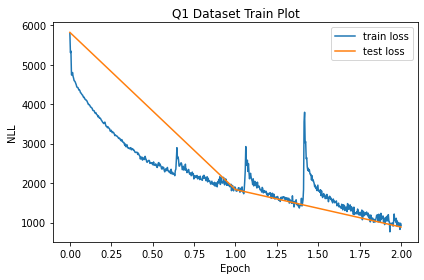

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


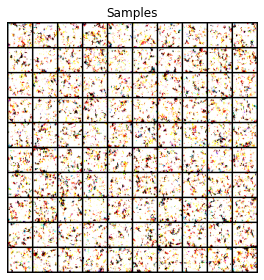

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


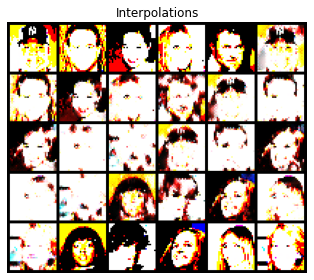

In [ ]:
q1_save_results(q1_a, 'a') # 2 ep

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

Epoch 1: train_loss = 2853.56984, test_loss = 1931.72774


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

Epoch 2: train_loss = 1462.04259, test_loss = 1002.88250


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

Epoch 3: train_loss = 862.63338, test_loss = 6341.14594


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

Epoch 4: train_loss = 1365.45425, test_loss = 437.56570


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

Epoch 5: train_loss = 160.80394, test_loss = -249.74916
Final Test Loss: -249.7492


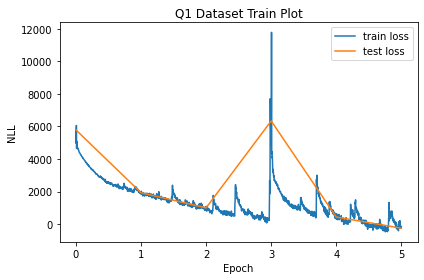

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


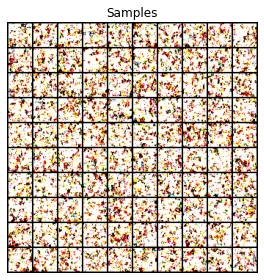

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


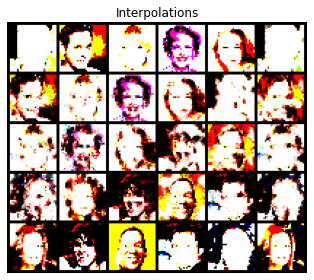

In [ ]:
q1_save_results(q1_a, 'a') # 5 ep

torch.Size([30, 3, 32, 32])
Final Test Loss: 0.4065


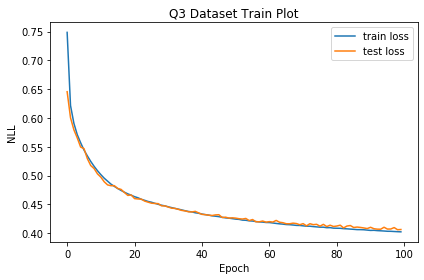

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


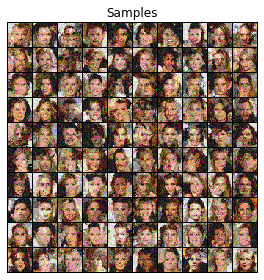

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


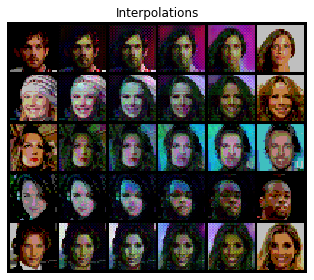

In [ ]:
q1_save_results(q1_a, 'a') # ref

## Part (b): Exploring bad masking schemes

The choice of masking or partitioning scheme affects the quality of the final flow model. In this part, design a *bad* masking scheme and train a model with it on the same CelebA dataset. 

**Provide the same deliverables as part (a)**

### Solution

In [ ]:
class BadAffineCoupling(nn.Module):
    def __init__(self, n_in=3, n_out=6, n_filters=128, n_blocks=2, mask_type=1): # n_blocks=8
        super().__init__()
        self.model = SimpleResnet(n_in, n_out)
        self.mask = self.build_mask(h=32, w=32, mask_type=mask_type)
        self.scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True)

    def build_mask(self, h, w, mask_type):
        if mask_type in [1, 2]:
            mask = torch.cat([torch.ones((h // 2, w)), 
                              torch.zeros((h - h // 2, w))]).to(device)
            mask = mask.float()[None, None, :, :]
            if mask_type == 2:
                mask = 1.0 - mask
            return mask
        else:
            mask = torch.cat([torch.ones((h, w // 2)), 
                              torch.zeros((h, w - w // 2))], dim=1).to(device)
            mask = mask.float()[None, None, :, :]
            if mask_type == 4:
                mask = 1.0 - mask
            return mask


    def forward(self, x, reverse=False):
        """
            В mask 1 стоит на тех местах, что в z тождественно будет равняться x,
            то есть для x_{1: d}
        """

        # batch_size = x.shape[0]
        # mask = self.mask.repeat(batch_size, 1)

        x_ = x * self.mask
        log_scale, t = torch.chunk(self.model(x_), 2, dim=1)
        log_scale = self.scale * torch.tanh(log_scale) + self.scale_shift


        # z = x * log_scale.exp() + t
        # z = z * (1.0 - self.mask)
        # z = z + x_

        # log_det_jacobian = (log_scale * (1.0 - self.mask)).sum().exp()
        # return z, log_det_jacobian

        ##############
        t = t * (1.0 - self.mask)
        log_scale = log_scale * (1.0 - self.mask)

        if reverse: 
            x = (x - t) * torch.exp(-log_scale)
        else:
            x = x * torch.exp(log_scale) + t
        return x, log_scale
        ###########

In [ ]:
class RealNVP(nn.Module):
    def __init__(self,):
        super().__init__()

        self.prior = torch.distributions.Normal(torch.tensor(0.).to(device), 
                                                torch.tensor(1.).to(device))
        
        self.transforms = nn.ModuleList([BadAffineCoupling(mask_type=1), ActNorm(3),
                                         BadAffineCoupling(mask_type=2), ActNorm(3),
                                         BadAffineCoupling(mask_type=3), ActNorm(3),
                                         BadAffineCoupling(mask_type=4), ActNorm(3)])


    def preprocess(self, x, alpha=0.05, max_value=4, reverse=False):
        if reverse:
            x = 1 + -1 / (x.exp() + 1) 
            x = x - alpha
            x = x / (1 - alpha)
            x = x * max_value
            return x
        else:
            x = x / max_value
            x = (1 - alpha) * x
            x = alpha + x
            return x.logit()

    
    def flow(self, x):
        z = self.preprocess(x)
        log_det = torch.zeros_like(x)

        for op in self.transforms:
            z, delta_log_det = op.forward(z)
            log_det += delta_log_det

        return z, log_det

    def invert_flow(self, z):
        for op in reversed(self.transforms):
            z, _ = op.forward(z, reverse=True)
        
        z = self.preprocess(z, reverse=True)
        return z


    def log_prob(self, x):
        z, log_det = self.flow(x)
        return torch.sum(log_det, dim=[1, 2, 3]) + torch.sum(self.prior.log_prob(z), dim=[1, 2, 3])

    def sample(self, num_samples):
        z = self.prior.sample([num_samples, 3, 32, 32])
        return self.invert_flow(z)

    def loss(self, x):
        return -self.log_prob(x).mean()

    def test(self, test_loader, bs=64,):
        with torch.no_grad():
            losses = []
            for batch in tqdm(test_loader):
                loss = self.loss(batch.float().to(device))
                losses.append(loss.item())
            return np.mean(losses)

    def fit(self, train_data, test_data, bs=64, num_epochs=100, lr=5e-4):
        train_loader = data.DataLoader(train_data, batch_size=bs, shuffle=True)
        test_loader = data.DataLoader(test_data, batch_size=bs, shuffle=False)

        optim = opt.Adam(self.parameters(), lr=lr)

        train_losses = []
        test_losses = [self.test(test_loader)]
        for epoch in tqdm(range(num_epochs)):
            losses = []
            for batch in tqdm(train_loader):
                loss = self.loss(batch.float().to(device))

                optim.zero_grad()
                loss.backward()
                optim.step()

                losses.append(loss.item())
                train_losses.append(loss.item())
            test_losses.append(self.test(test_loader))
            print(f'Epoch {epoch + 1}: train_loss = {np.mean(losses):.5f}, test_loss = {test_losses[-1]:.5f}')
            
        return train_losses, test_losses

In [ ]:
def q1_b(train_data, test_data):
    """
    train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, 3, H, W) of samples with values in [0, 1]
    - a numpy array of size (30, 3, H, W) of interpolations with values in [0, 1].
    """
  
    model = RealNVP()
    model.to(device)
    train_data = torch.Tensor(train_data).permute(0, 3, 1, 2)
    test_data = torch.Tensor(test_data).permute(0, 3, 1, 2)

    model.train()
    train_losses, test_losses = model.fit(train_data, test_data, num_epochs=2)
  
    model.eval()
    samples = model.sample(num_samples=100).detach().cpu().numpy().transpose(0, 2, 3, 1)

    ids = torch.randint(0, len(test_data), (10,))
    z, _ = model.flow(test_data[ids].to(device))

    interpolations = []
    with torch.no_grad():
      for alpha in np.linspace(0, 1, 6):
          new_z = alpha * z[:5] + (1 - alpha) * z[5:]
          new_x = model.invert_flow(new_z) # [5, 3, H, W]
          interpolations.append(new_x.detach().cpu().numpy().transpose(0, 2, 3, 1))
    interpolations = np.concatenate(interpolations)

    return train_losses, test_losses, samples, interpolations

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

Epoch 1: train_loss = 4601.37170, test_loss = 4176.32841


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

Epoch 2: train_loss = 4022.52140, test_loss = 3877.45966


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

Epoch 3: train_loss = 3766.88114, test_loss = 3663.79990


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

Epoch 4: train_loss = 3597.05081, test_loss = 3541.43752


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

Epoch 5: train_loss = 3477.88229, test_loss = 3409.41368


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

Epoch 6: train_loss = 3377.41339, test_loss = 3341.26035


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

Epoch 7: train_loss = 3273.71465, test_loss = 3245.58635


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

Epoch 8: train_loss = 3176.15907, test_loss = 3219.35277


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

Epoch 9: train_loss = 3109.16919, test_loss = 3064.65873


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

Epoch 10: train_loss = 3044.06835, test_loss = 2953.58988
Final Test Loss: 2953.5899


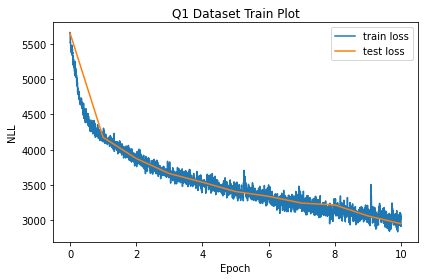

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


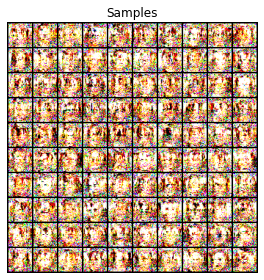

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


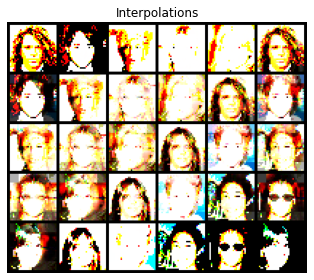

In [ ]:
q1_save_results(q1_b, 'b') # 10 ep

torch.Size([30, 3, 32, 32])
Final Test Loss: 0.6963


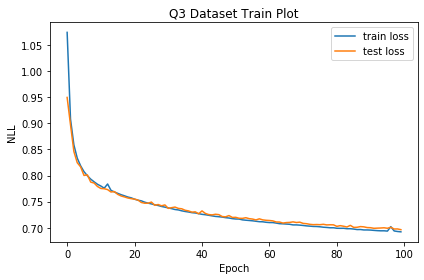

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


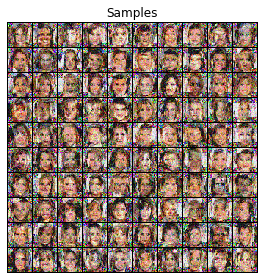

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


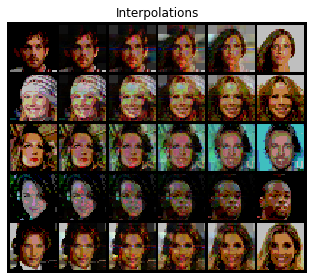

In [ ]:
q1_save_results(q1_b, 'b') # ref

## Bonus 1: Multiscale RealNVP
Following the alternating checkerboard, channel squeeze, and channel partition scheme used in https://arxiv.org/abs/1605.08803, learn a multiscale RealNVP model on our CelebA dataset used in Question 3. We expect the same deliverables as in Question 3; additionally, make sure to include analysis on any difference in qualitative or quantitative differences you see in the results.

In [ ]:
def b1(train_data, test_data):
  """
  train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, 3, H, W) of samples with values in [0, 1]
  - a numpy array of size (30, 3, H, W) of interpolations with values in [0, 1].
  """
  
  """ YOUR CODE HERE """

In [ ]:
q1_save_results(b1, 'bonus1')

## Bonus 2: Glow
The Glow paper introduces the invertible 1x1 convolution as a replacement for the permutation scheme that follows the channel squeezing step. Use this in your model from Question 3, and report the same deliverables. Make sure to include analysis on any difference in qualitative or quantitative differences you see in the results.

In [ ]:
def b2(train_data, test_data):
  """
  train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, 3, H, W) of samples with values in [0, 1]
  - a numpy array of size (30, 3, H, W) of interpolations with values in [0, 1].
  """
  
  """ YOUR CODE HERE """

In [ ]:
q1_save_results(b2, 'bonus2')